# PyTorch Model Utils Test Model

Test notebook to demonstrate how to properly use the functions included in utils. We will use a small custom Flipout CNN with CIFAR10.

## Imports and Setup

In [17]:
import os
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn
from torchmetrics import Accuracy

from utils import train, learning_curves, evaluate, uncertainty_quantification

## Dataset Creation

In [18]:
train_trans = transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.5,), (0.5,)),
                                  transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                                  transforms.RandomHorizontalFlip(), ])

val_trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
root = '../data'
train_ds = datasets.CIFAR10(root=root, train=True, transform=train_trans, download=True)
val_ds = datasets.CIFAR10(root=root, train=False, transform=val_trans, download=True)
test_ds = datasets.CIFAR10(root=root, train=False, transform=val_trans, download=True)

classes = train_ds.classes
print(classes)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
batch_size=256
lr = 1e-3
total_classes = len(classes)

# Create Dataloaders
train_loader = torch.utils.data.DataLoader(
                dataset=train_ds,
                batch_size=batch_size,
                shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_ds,
                batch_size=batch_size,
                shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test_ds,
                batch_size=batch_size,
                shuffle=False)

dataloads = {'train':train_loader,'val':val_loader,'test':test_loader}

## Visualize the Training Images

In [20]:
def imshow(inp, ax, title=None):
    """imshow for tensor

    Args:
        inp (torch tensor image): Input image
        title (str, optional): title for image. Defaults to None.
    """
    # Put channels last for matplotlib
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    # Reverse normalize
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)

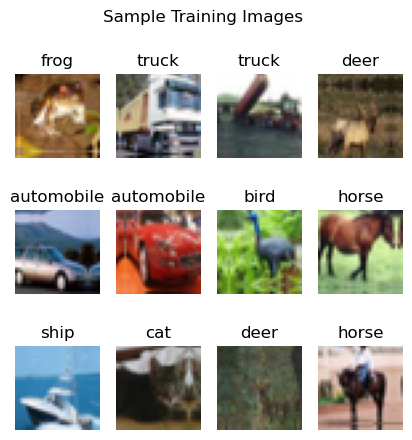

In [21]:
fig, axes = plt.subplots(3,4, figsize=(5,5))
for i in range(12):
    ax = axes.ravel()[i]
    # Don't show classes that we excluded
    img, true_class = train_ds[i]
    name = classes[true_class]
    imshow(img, ax, name)
    ax.axis('off')
    
fig.suptitle('Sample Training Images')
fig.subplots_adjust(top=0.88)
plt.show()

## Build Model

We use a simple CNN here for proof of concept.

In [22]:
const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Flipout",  # Flipout or Reparameterization
    "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
    "moped_delta": 0.5,
}
    
class Net(nn.Module):
    """Simple CNN. Architecture from:
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

dnn_to_bnn(model, const_bnn_prior_parameters) # Convert to Flipout model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2dFlipout()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2dFlipout()
  (fc1): LinearFlipout()
  (fc2): LinearFlipout()
  (fc3): LinearFlipout()
)

## Train Model

We are using an Adam optimizer here and CrossEntropyLoss(), which combines the effect of Softmax and NLLLoss(). This simplier implementation will require an additional step in inference of adding Softmax back in.

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
metrics = {'train': Accuracy(task='multiclass', num_classes=total_classes).to(device),
           'val': Accuracy(task='multiclass', num_classes=total_classes).to(device),
           'test': Accuracy(task='multiclass', num_classes=total_classes).to(device),
           'short': 'acc',
           'name': 'Accuracy'}

In [24]:
model_path = 'test_nb_model.pth'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

results = train(model = model, 
                        dataloads = dataloads, 
                        criterion = criterion, 
                        optimizer = optimizer, 
                        metrics = metrics,
                        epochs = 3, 
                        val_patience = 3, 
                        model_path = model_path,
                        bayesian = True)

Epoch: 1/3:   8%|▊         | 16/196 [00:05<01:01,  2.94batches/s, train_loss=1.46, val_loss=nan, train_acc=0.512, val_acc=nan]


KeyboardInterrupt: 

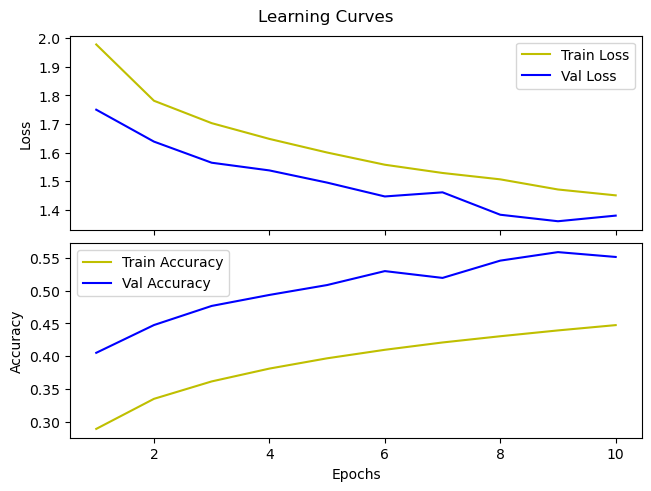

In [ ]:
# Plot learning curves 
fig = plt.figure(layout='constrained')
fig.suptitle(f'Learning Curves')
learning_curves(results, fig, metrics)
plt.show()

## Model Evaluation

For Bayesian models, there are several metrics to consider. 
- NLL (without KL divergence)
- Calibrated Uncertainy
- Uncertainty Quantification
- Individual Image Analysis

### Make MC Inferences

With a deterministic model, we will get the same outputs every time we run inference. Bayesian models have a distribution instead of a single value for each weight. Each inference samples from that distribution, producing different results each time. This is paramount for bayesian models as it allows analysis of the variance and entropy of the samples. Here we apply 25 different inferences to model the distribution of the weights over the output of the model. More is always better, but can be computationally expensive.

In [ ]:
num_mc_inferences = 5
y_preds = torch.zeros(num_mc_inferences,len(dataloads['test'].dataset),total_classes)
for i in range(num_mc_inferences):
    y_preds[i,:,:] = evaluate(model, dataloads['test'], criterion, metrics)

y_true = torch.nn.functional.one_hot(torch.tensor(test_ds.targets),num_classes=total_classes)

100%|██████████| 40/40 [00:10<00:00,  3.76batches/s, loss=1.25, acc=0.547] 


In [ ]:
stats = uncertainty_quantification(y_preds)

### Aleatoric and Epistemic Uncertainty

Aleatoric uncertainty is the uncertainty inherent to the model or problem. It cannot be reduced further without changing the model architecture or transforming the data before sending it through the model. Epistemic uncertainty is uncertainty that is a result of the insufficient training data. If a model is unfamiliar with a particular type of data (like say an airplane), the epistemic uncertainty will be high and can be reduced by adding more images of planes to the training set. 

This methodology works best with highly accurate models. The decomposition of uncertainty is not perfect; there is an epistemic component to aleatoric uncertainty. Being able to drive down aleatoric with a high performing model makes the differences more starck.

In [ ]:
# The mean over the samples is a poor metric - each sample is unique and requires specific analysis,
# but this gives a starting point to understanding the benefits of bayesian networks
mean_ale = np.mean(stats['aleatoric'])
mean_epi = np.mean(stats['epistemic'])
print(f'Aleatoric: {mean_ale:.4f}')
print(f'Epistemic: {mean_epi:.4f}')

Aleatoric: 0.5854
Epistemic: 0.0121


## Visualizing Model Predictions

Let's start by visualizing some of the images and our predictions.

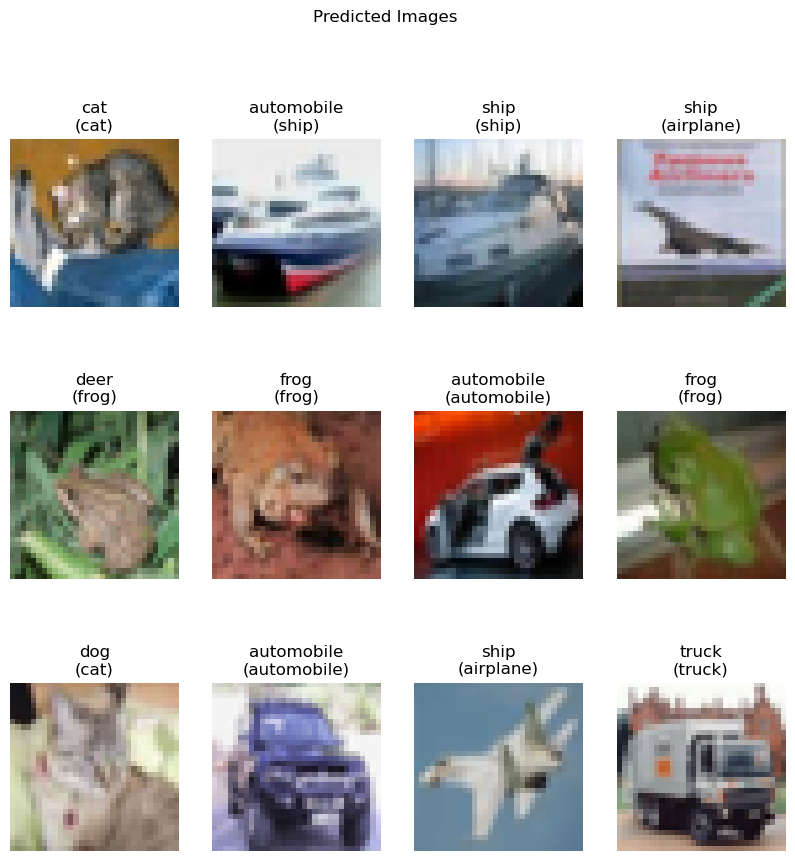

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    img, true_class = test_ds[i]
    true_class = classes[true_class]
    pred_id = stats['max_pred'][i]
    pred_class = classes[pred_id]
    name = f'{pred_class}\n({true_class})'
    imshow(img, ax, name)
    ax.axis('off')
    
fig.suptitle('Predicted Images')
fig.subplots_adjust(top=0.88)
plt.show()

Here we start reviewing the logits from our MC Inferences with each image and its classification. The more constrained each class is, the more confident the model is in its prediction. If there is lots of variance in a class or more than one class has high logit outputs, then thats an indication that the model isn't sure what the image actually is.

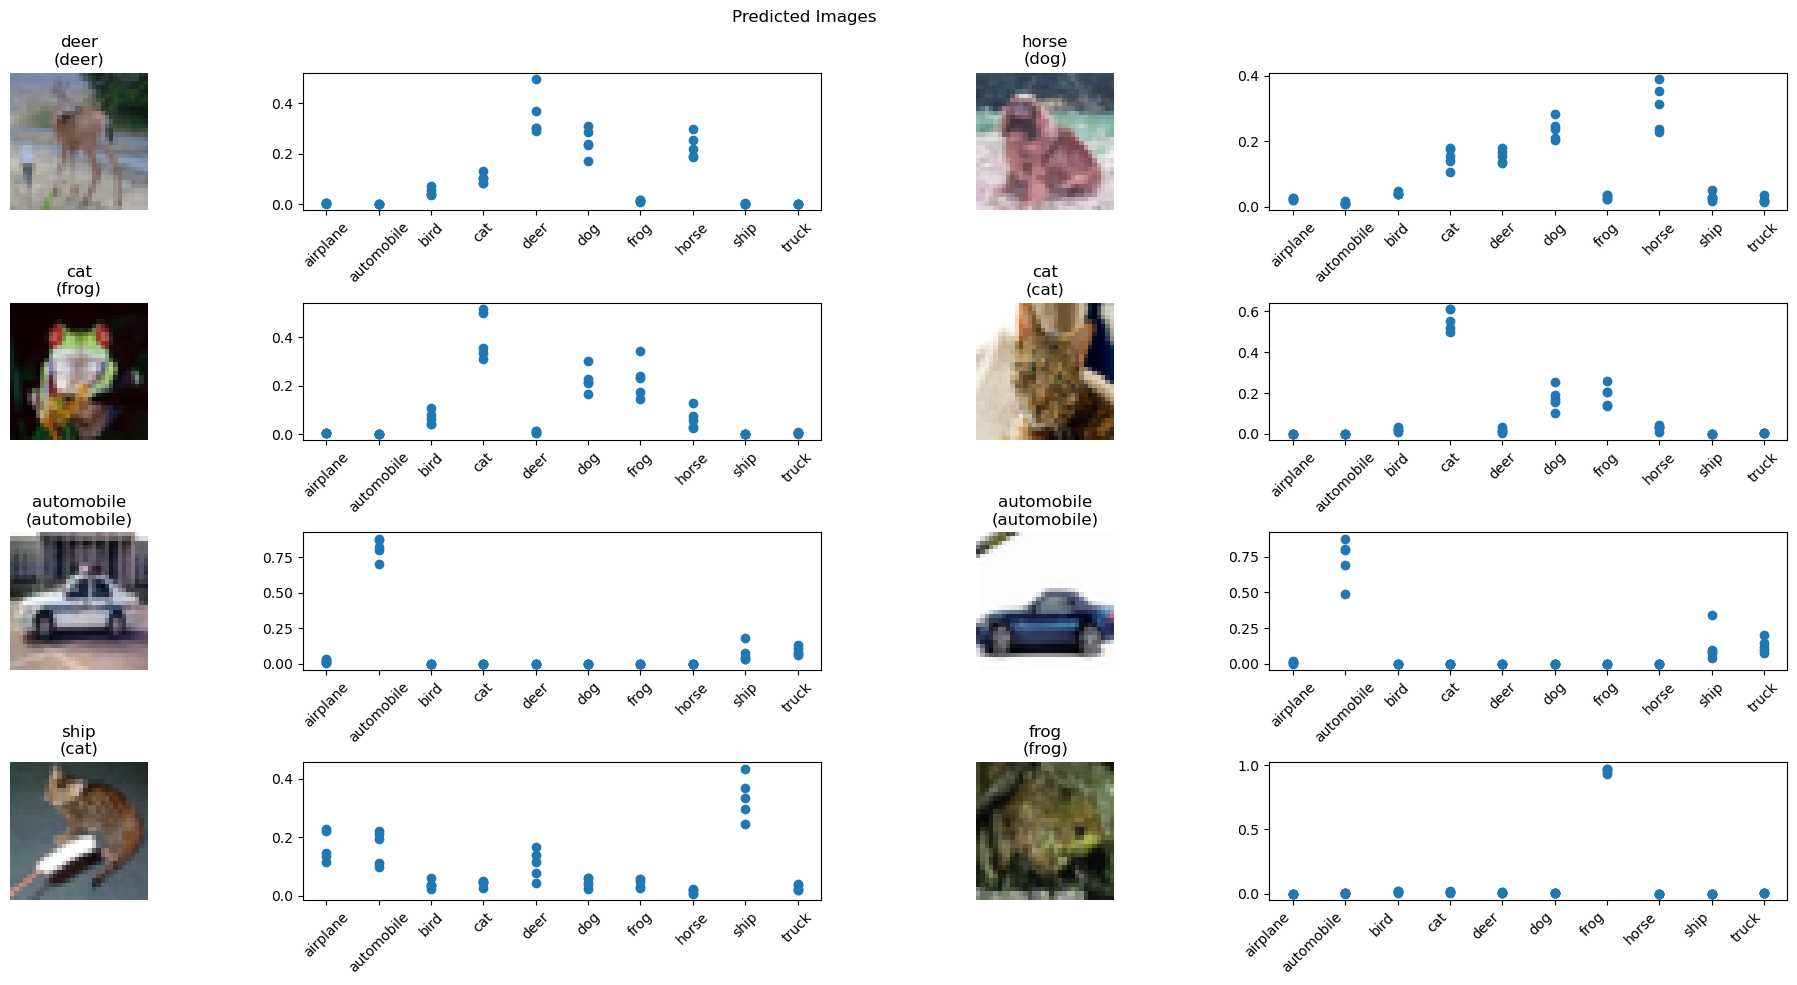

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(20,10))
x = np.repeat(test_ds.classes,num_mc_inferences)
i = 100
for j, axs in enumerate(axes.ravel()):
    if j % 2 == 0:
        logits = y_preds[:,i,:].numpy()
        max_pred = np.argmax(np.mean(logits, axis=0))
        img, true_class = test_ds[i]
        true_class = classes[true_class]
        pred_class = classes[max_pred]
        name = f'{pred_class}\n({true_class})'
        imshow(img, axs, name)
        axs.axis('off')
    else:
        axs.scatter(x=x, y=logits.T.flatten())
        axs.tick_params(axis='x',labelrotation=45)
        i += 1
plt.xticks(ha='right')
fig.suptitle('Predicted Images')
plt.tight_layout()
plt.show()